In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Baffin = pd.read_excel(filepath, sheet_name='Baffin-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Baffin)
fp.date_time(Baffin)

,Extent,Date
0,1090625.815,1979-01-01
1,1157634.866,1979-02-01
2,1299583.477,1979-03-01
3,1137194.680,1979-04-01
4,983083.453,1979-05-01
...,...,...
533,781460.891,2023-06-01
534,331845.048,2023-07-01
535,99334.625,2023-08-01
536,49359.723,2023-09-01


In [5]:
scaler = MinMaxScaler()
Baffin['Extent'] = scaler.fit_transform(Baffin['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 2
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Baffin['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((525, 12, 1), (525,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Baffin_model_LT2/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 18s 222ms/step - loss: 0.2345 - root_mean_squared_error: 0.4842 - val_loss: 0.1990 - val_root_mean_squared_error: 0.4461
Epoch 2/50
53/53 [==============================] - 9s 169ms/step - loss: 0.1378 - root_mean_squared_error: 0.3713 - val_loss: 0.0516 - val_root_mean_squared_error: 0.2272
Epoch 3/50
53/53 [==============================] - 9s 179ms/step - loss: 0.0516 - root_mean_squared_error: 0.2272 - val_loss: 0.0391 - val_root_mean_squared_error: 0.1978
Epoch 4/50
53/53 [==============================] - 11s 209ms/step - loss: 0.0390 - root_mean_squared_error: 0.1976 - val_loss: 0.0268 - val_root_mean_squared_error: 0.1636
Epoch 5/50
53/53 [==============================] - 9s 171ms/step - loss: 0.0296 - root_mean_squared_error: 0.1721 - val_loss: 0.0176 - val_root_mean_squared_error: 0.1326
Epoch 6/50
53/53 [==============================] - 10s 201ms/step - loss: 0.0222 - root_mean_squared_error: 0.1490 - val_loss: 0.0116 - v

53/53 [==============================] - 2s 35ms/step - loss: 0.0072 - root_mean_squared_error: 0.0849 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0587
Epoch 33/50
53/53 [==============================] - 2s 35ms/step - loss: 0.0073 - root_mean_squared_error: 0.0855 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0563
Epoch 34/50
53/53 [==============================] - 2s 34ms/step - loss: 0.0074 - root_mean_squared_error: 0.0862 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0543
Epoch 35/50
53/53 [==============================] - 2s 35ms/step - loss: 0.0074 - root_mean_squared_error: 0.0858 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0550
Epoch 36/50
53/53 [==============================] - 2s 35ms/step - loss: 0.0070 - root_mean_squared_error: 0.0839 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0581
Epoch 37/50
53/53 [==============================] - 2s 33ms/step - loss: 0.0081 - root_mean_squared_error: 0.0901 - val_loss: 0.0030 - val_root_mean_sq

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

5.408694918950399 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

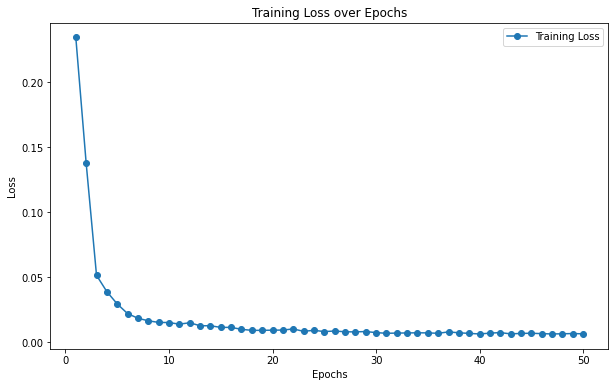

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

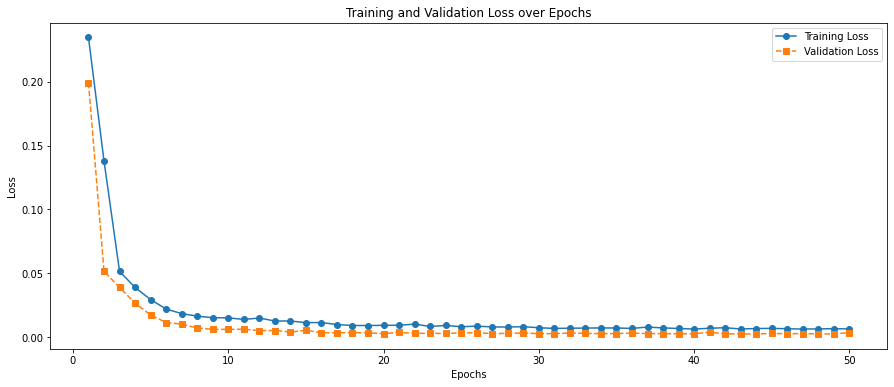

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Baffin_model_LT2/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 17ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.07064308907024217
MAE : 0.05240445660010742


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,8.290704e+05,587385.424
1,4.134997e+05,171258.094
2,7.836979e+04,46930.952
3,9.640419e+04,27600.624
4,2.871458e+05,61057.940
5,5.900741e+05,291275.949
6,9.040972e+05,678576.504
7,1.084894e+06,974461.347
8,1.221100e+06,1181121.087
9,1.231285e+06,1236299.254


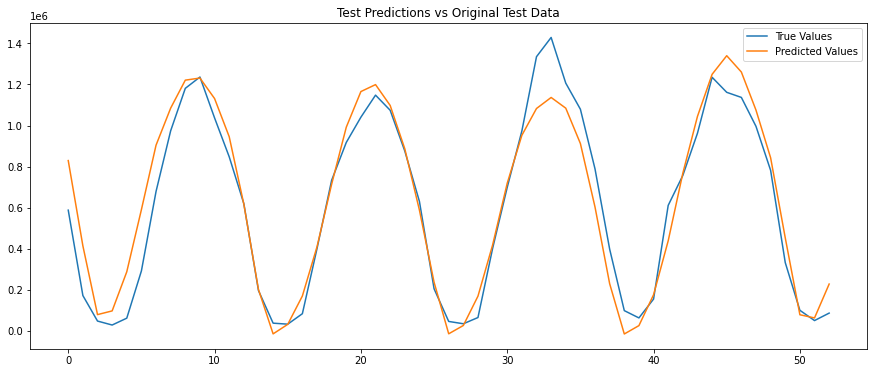

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 13ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

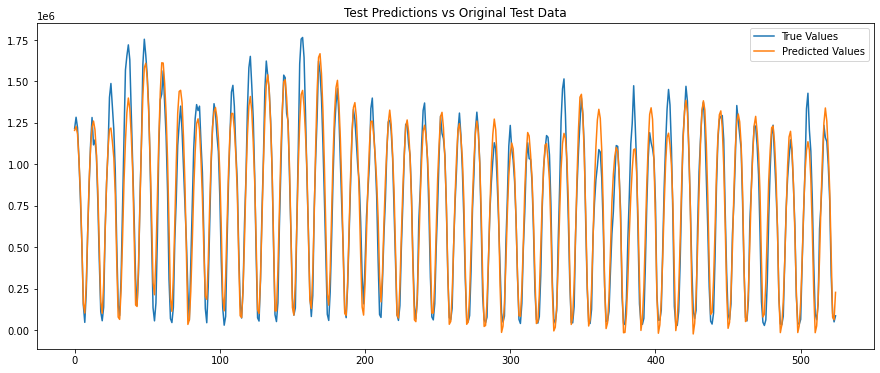

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()